In [30]:
import numpy as np
import matplotlib.pyplot as plt   
import IPython.display as ipd
import torch 

frame_size = 512
shift_size = 128
PI = 3.14159265358979323846

# type 1

(1022,)


Text(0.5, 1.0, 'window')

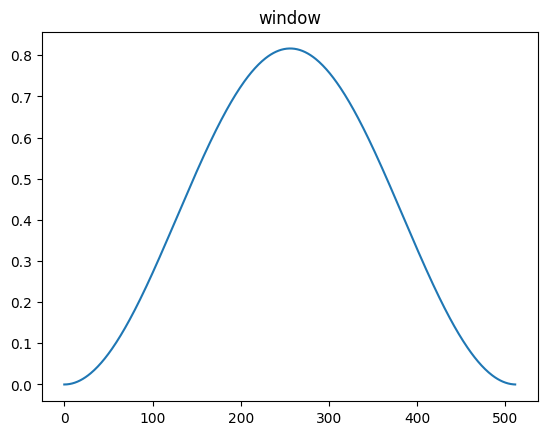

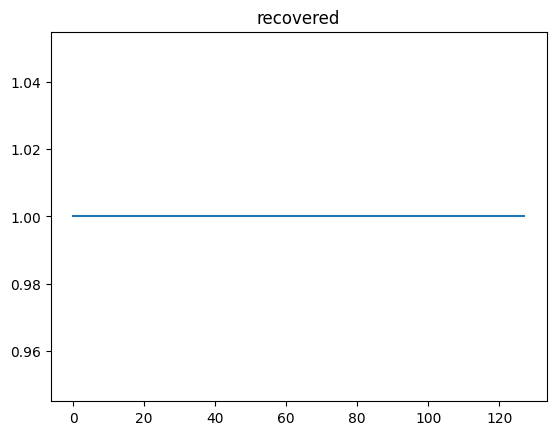

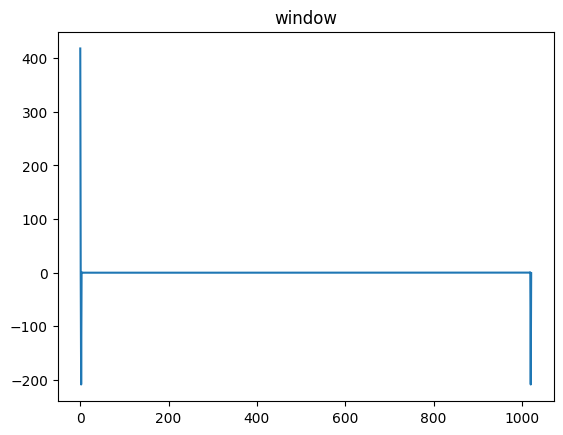

In [35]:
hann = np.zeros(frame_size)
for i in range(frame_size) :
  hann[i] = 0.5 * (1.0 - np.cos(2.0 * 3.14159265358979323846 * i / (frame_size))) / np.sqrt((frame_size * 0.3750) / shift_size);
plt.figure()
plt.plot(hann)
plt.title("window")

# reconstruiction test
recovered = np.zeros(shift_size)
for i in range(4) :
    for j in range(shift_size):
        recovered[j] += hann[i*shift_size + j]**2
plt.figure()
plt.plot(recovered)
plt.title("recovered")   


plt.figure()
plt.plot(np.fft.hfft(hann[:frame_size]))
print(np.fft.hfft(hann).shape)
plt.title("window")

# type 2

Text(0.5, 1.0, 'recovered : hann_reg')

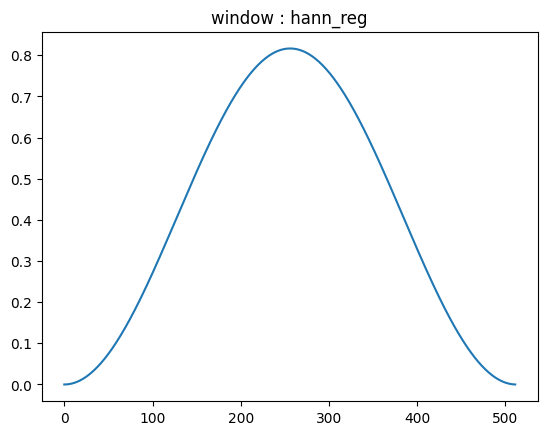

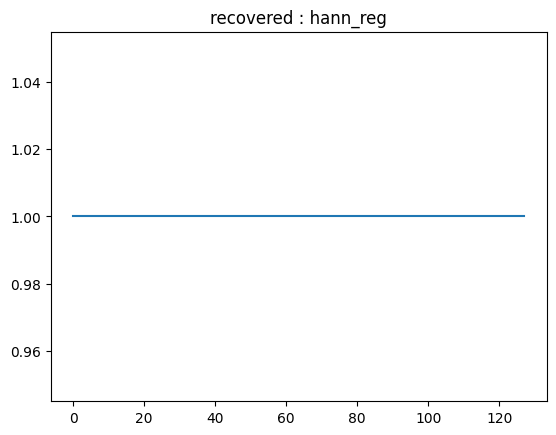

In [52]:
hann_reg = np.zeros(frame_size)
for i in range(frame_size) :
    hann_reg[i] = 0.5 * (1.0 - np.cos(2.0 * MATLAB_pi * (i / frame_size)));
tmp = 0
for i in range(frame_size) :
    tmp += hann_reg[i] * hann_reg[i];
tmp /= shift_size;
tmp = np.sqrt(tmp);

for i in range(frame_size) :
    hann_reg[i] /= tmp;
plt.figure()
plt.plot(hann_reg)
plt.title("window : hann_reg")

# reconstruiction test
recovered = np.zeros(shift_size)
for i in range(4) :
    for j in range(shift_size):
        recovered[j] += hann_reg[i*shift_size + j]**2
plt.figure()
plt.plot(recovered)
plt.title("recovered : hann_reg")    

In [38]:
np.sum(hann-hann2)

7.57273204646941e-14

# Tpye torch - no regularization

Text(0.5, 1.0, 'recovered : torch hann')

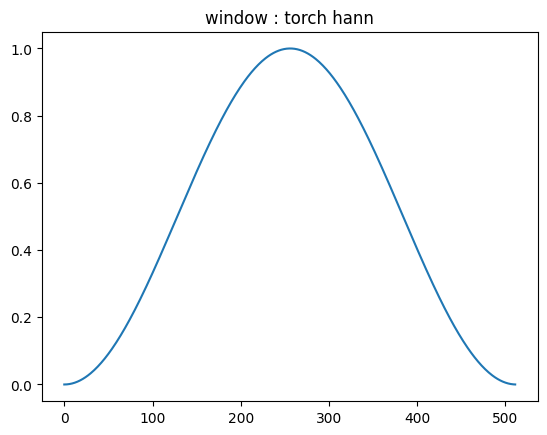

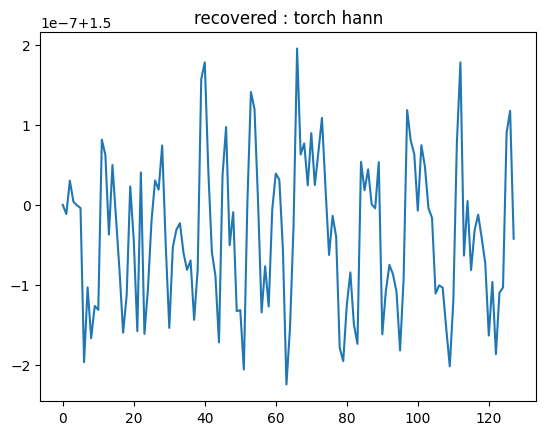

In [53]:
hann_torch = torch.hann_window(frame_size).numpy()

plt.figure()
plt.plot(hann_torch)
plt.title("window : torch hann")

# reconstruiction test
recovered = np.zeros(shift_size)
for i in range(4) :
    for j in range(shift_size):
        recovered[j] += hann_torch[i*shift_size + j]**2
plt.figure()
plt.plot(recovered)
plt.title("recovered : torch hann")   

Text(0.5, 1.0, 'recovered : hann default')

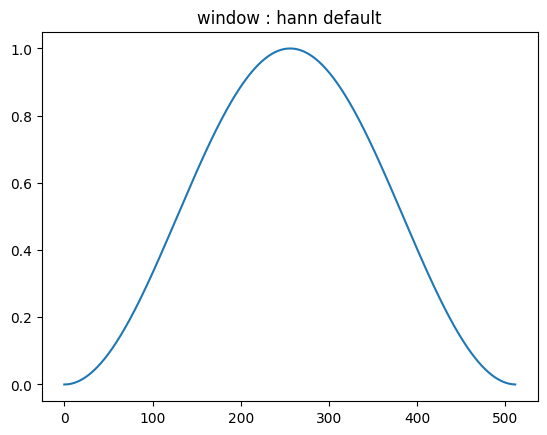

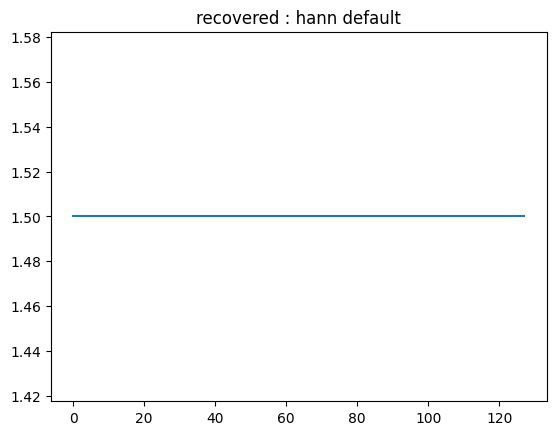

In [54]:
hann_default = np.zeros(frame_size)
for i in range(frame_size) :
    hann_default[i] =0.5 * (1.0 - np.cos(2.0 * MATLAB_pi * (i / frame_size)));

plt.figure()
plt.plot(hann_default)
plt.title("window : hann default")

# reconstruiction test
recovered = np.zeros(shift_size)
for i in range(4) :
    for j in range(shift_size):
        recovered[j] += hann_default[i*shift_size + j]**2
plt.figure()
plt.plot(recovered)
plt.title("recovered : hann default")    

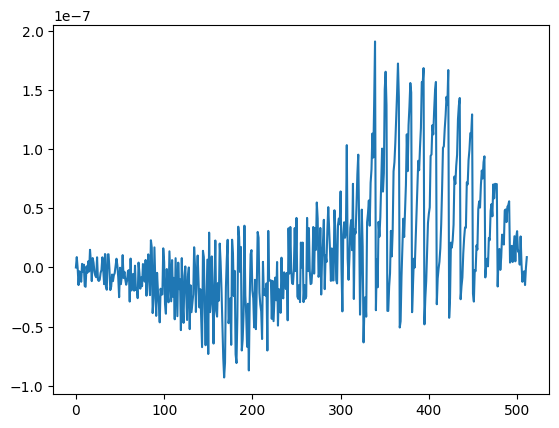

In [50]:

diff = hann_default - hann_torch
plt.figure()
plt.plot(diff)

# does torch STFT not along with custom window?

In [72]:
x = torch.rand(2,16000)

X_1 = torch.stft(x, n_fft = frame_size, hop_length = shift_size, window=torch.from_numpy(hann_torch),return_complex=True)
y_1 = torch.istft(X_1, frame_size, shift_size, frame_size, window=torch.from_numpy(hann_torch))

print("Torch 기본 hann window와 기본 STFT")
print(torch.sum(torch.abs(x-y_1)))



X_2 = torch.stft(x, n_fft = frame_size, hop_length = shift_size, window=torch.from_numpy(hann_reg),return_complex=True)
y_2 = torch.istft(X_2, frame_size, shift_size, frame_size, window=torch.from_numpy(hann_reg))

print("정규화된 hann window와 기본 STFT")
print(torch.sum(torch.abs(x-y_2)))

Torch 기본 hann window와 기본 STFT
tensor(0.0013)
정규화된 hann window와 기본 STFT
tensor(2.3991e-12, dtype=torch.float64)


In [ ]:
def custom_stft(signal, n_fft, hop_length=None, win_length=None, window=None, center=True, pad_mode='reflect'):
    """
    STFT를 PyTorch를 사용하여 직접 구현한 함수입니다.

    Args:
        signal (torch.Tensor): 입력 신호 (1D 텐서).
        n_fft (int): FFT 크기.
        hop_length (int): 프레임 간 간격. 기본값은 win_length // 4.
        win_length (int): 윈도우 크기. 기본값은 n_fft.
        window (torch.Tensor): 적용할 윈도우 함수. 기본값은 Hann 윈도우.
        center (bool): 신호를 중심에 패딩할지 여부.
        pad_mode (str): 패딩 방식. 기본값은 'reflect'.

    Returns:
        torch.Tensor: STFT 결과 (2D 복소수 텐서).
    """
    if win_length is None:
        win_length = n_fft
    if hop_length is None:
        hop_length = win_length // 4
    if window is None:
        window = torch.hann_window(win_length)

    # 입력 신호 패딩
    if center:
        pad_amount = n_fft // 2
        signal = torch.nn.functional.pad(signal, (pad_amount, pad_amount), mode=pad_mode)

    # 신호를 슬라이딩 윈도우로 분할
    num_frames = 1 + (len(signal) - n_fft) // hop_length
    frames = torch.stack([signal[i * hop_length:i * hop_length + n_fft] for i in range(num_frames)])

    # 윈도우 함수 적용
    frames = frames * window

    # FFT 수행
    stft_result = torch.fft.rfft(frames, n=n_fft, dim=-1)

    return stft_result


import torch

def custom_istft(stft_matrix, n_fft, hop_length=None, win_length=None, window=None, center=True, signal_length=None):
    """
    iSTFT를 PyTorch를 사용하여 직접 구현한 함수입니다.

    Args:
        stft_matrix (torch.Tensor): STFT 결과 (복소수 텐서).
        n_fft (int): FFT 크기.
        hop_length (int): 프레임 간 간격. 기본값은 win_length // 4.
        win_length (int): 윈도우 크기. 기본값은 n_fft.
        window (torch.Tensor): 적용할 윈도우 함수. 기본값은 Hann 윈도우.
        center (bool): 신호를 중심에 패딩했는지 여부.
        signal_length (int): 복원할 신호 길이.

    Returns:
        torch.Tensor: 시간 영역 신호.
    """
    if win_length is None:
        win_length = n_fft
    if hop_length is None:
        hop_length = win_length // 4
    if window is None:
        window = torch.hann_window(win_length)

    # 복소수 텐서를 시간 영역으로 변환
    frames = torch.fft.irfft(stft_matrix, n=n_fft, dim=-1)

    # 윈도우 크기에 맞게 잘라내기
    frames = frames[..., :win_length]

    # 오버랩-애드 방식으로 신호 복원
    signal_length = signal_length or (frames.shape[0] * hop_length + n_fft)
    signal = torch.zeros(signal_length, dtype=torch.float32)

    window_sum = torch.zeros(signal_length, dtype=torch.float32)

    for i, frame in enumerate(frames):
        start = i * hop_length
        end = start + win_length
        signal[start:end] += frame * window
        window_sum[start:end] += window**2

    # 윈도우의 합이 0이 아닌 영역에서만 보정
    nonzero_indices = window_sum > 1e-8
    signal[nonzero_indices] /= window_sum[nonzero_indices]

    # 중심 패딩 제거
    if center:
        signal = signal[n_fft // 2:-(n_fft // 2)]

    return signal

def hann(frame_size,shift_size):
    PI = 3.14159265358979323846
    window = torch.zeros(self.frame_size)
    # Hann window regularized by energy
    for i in range(frame_size) :
        window[i] = torch.tensor(0.5 * (1.0 - np.cos(2.0 * PI * (i / frame_size))))
    tmp = 0
    for i in range(frame_size) :
        tmp += window[i] * window[i]
    tmp /= shift_size;
    tmp = torch.sqrt(tmp);

    for i in range(frame_size) :
        window[i] /= tmp;
return window